In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score, matthews_corrcoef, accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
# Read Data
data_all = pd.read_csv('C:/Users/pierc/Desktop/kaggle credit card/creditcard.csv')

In [3]:
# check na
na_col = data_all.isnull().sum()
na_col = na_col[na_col > 0]
print(na_col)

Series([], dtype: int64)


In [4]:
# Split
X = data_all.drop('Class', axis=1)
y = data_all['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

# First Modeling

### 訓練模型有：Random Forest、XGBoost、Bagging、Logistic、MLP五個常見的模型。
### 評斷標準：Precision、Recall、AUC等

In [5]:
# Model
models = []
models.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
models.append(['XGB', XGBClassifier(n_jobs=-1)])
models.append(['Bagging', BaggingClassifier(n_jobs=-1)])
models.append(['Logistic', LogisticRegressionCV(n_jobs=-1)])
models.append(['MLP', MLPClassifier()])
MLA_compare = pd.DataFrame(columns=['Name', 'Accuracy','Precision', 'Recall', 'F1', 'AUC', 'MCC'])
row_index = 0

for name, model in models:
    model.fit(X_train, y_train)
    y_pre = model.predict(X_test)
    MLA_compare.loc[row_index, 'Name'] = name
    MLA_compare.loc[row_index, 'Accuracy'] = accuracy_score(y_test, y_pre)
    MLA_compare.loc[row_index, 'Precision'] = precision_score(y_test, y_pre)
    MLA_compare.loc[row_index, 'Recall'] = recall_score(y_test, y_pre)
    MLA_compare.loc[row_index, 'F1'] = f1_score(y_test, y_pre)
    MLA_compare.loc[row_index, 'AUC'] = roc_auc_score(y_test, y_pre)
    MLA_compare.loc[row_index, 'MCC'] = matthews_corrcoef(y_test, y_pre)
    row_index +=1
print(MLA_compare)

C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            Name  Accuracy Precision    Recall        F1       AUC       MCC
0  Random Forest  0.999631  0.931507  0.809524  0.866242  0.904718  0.868198
1            XGB  0.999614  0.918919  0.809524  0.860759  0.904709  0.862301
2        Bagging  0.999614  0.930556  0.797619  0.858974  0.898766  0.861341
3       Logistic  0.999386  0.865672  0.690476  0.768212  0.845159  0.772835
4            MLP  0.998982     0.825  0.392857  0.532258  0.696367  0.568906


### (1)、Accuracy不是好的評斷方法，原因是機器只要猜該用戶是Normal就會中。
### (2)、對於銀行來說比較不希望發生型一誤差(他實際是Fraud但模型確判斷他不是：False Positive)。
### (3)、Recall 代表我訓練的模型，用戶為 Nomal 的我抓出幾個；Precision代表我的模型預測中有多少是準確的。
### (4)、這題 Precision判別方法較不好，原因是實際為 Nomal 的資料數太多，系統不太會預測它是 Fraud。

# Feature Engineer

In [6]:
data_all = pd.read_csv('C:/Users/pierc/Desktop/kaggle credit card/creditcard.csv')
# EDA
print(data_all['Class'].value_counts())
data_all[['Time', 'Amount', 'Class']].describe()

0    284315
1       492
Name: Class, dtype: int64


,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


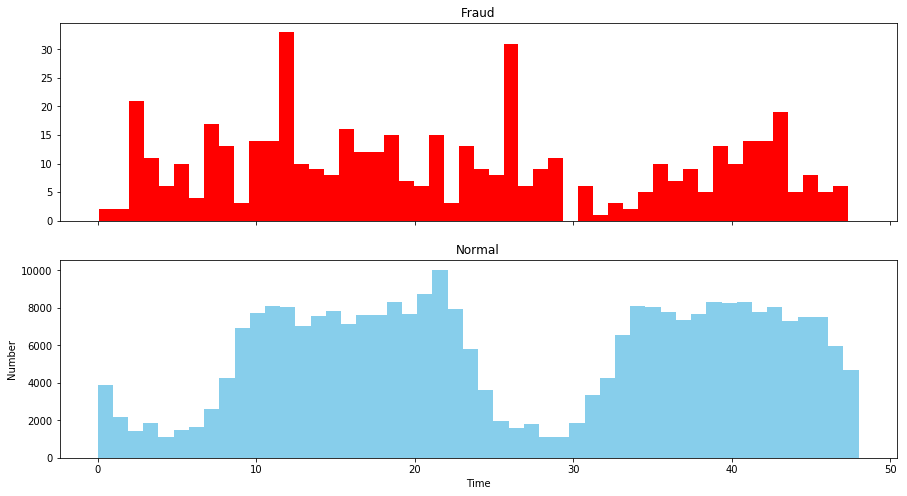

In [7]:
# Time
data_all.loc[:,'Time'] = data_all.Time / 3600

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))
ax1.hist(data_all.Time[data_all.Class == 1], bins=50, color='red', lw=0)
ax1.set_title('Fraud')

ax2.hist(data_all.Time[data_all.Class == 0], bins=50, color='skyblue', lw=0)
ax2.set_title('Normal')

plt.xlabel('Time')
plt.ylabel('Number')
plt.show()

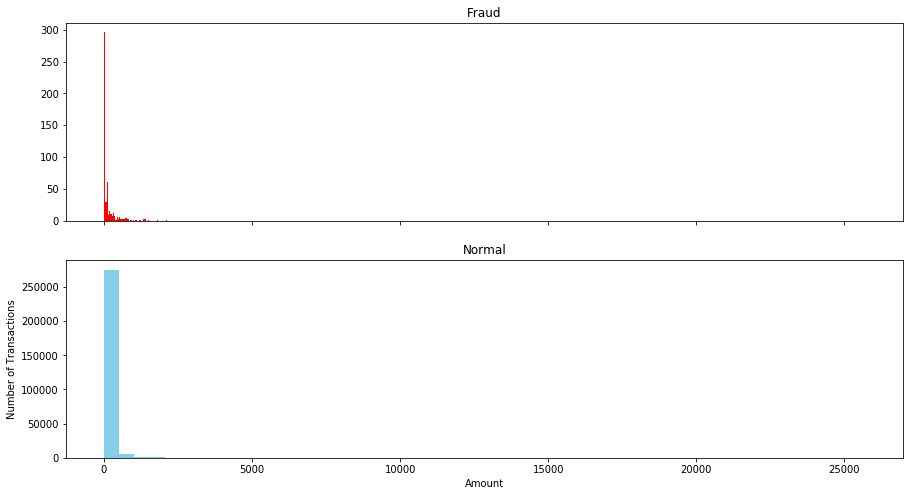

In [8]:
# Amount
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,8))

ax1.hist(data_all.Amount[data_all.Class == 1], bins=50, color='red', lw=0)
ax1.set_title('Fraud')

ax2.hist(data_all.Amount[data_all.Class == 0], bins=50, color='skyblue', lw=0)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.show()

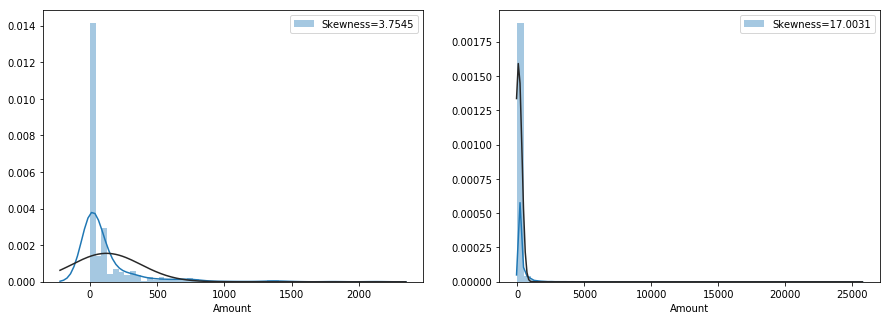

In [9]:
# Skewness
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(data_all.Amount[data_all.Class == 1], fit=stats.norm, label='Skewness=%.4f'%data_all.Amount[data_all.Class == 1].skew())
plt.legend()
plt.subplot(1,2,2)
sns.distplot(data_all.Amount[data_all.Class == 0], fit=stats.norm, label='Skewness=%.4f'%data_all.Amount[data_all.Class == 0].skew())
plt.legend()
plt.show()

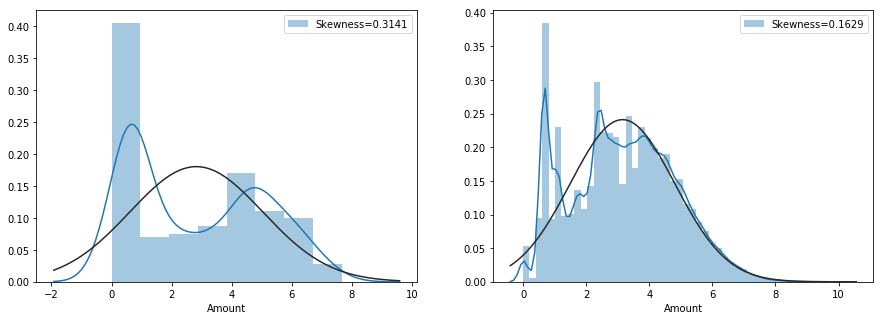

In [10]:
# 消除Skewness
data_all['Amount'] = np.log1p(data_all['Amount'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(data_all.Amount[data_all.Class == 1], fit=stats.norm, label='Skewness=%.4f'%data_all.Amount[data_all.Class == 1].skew())
plt.legend()
plt.subplot(1,2,2)
sns.distplot(data_all.Amount[data_all.Class == 0], fit=stats.norm, label='Skewness=%.4f'%data_all.Amount[data_all.Class == 0].skew())
plt.legend()
plt.show()

In [11]:
# Split
X = data_all.drop('Class', axis=1)
y = data_all['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

### 常見處理 Unbalance 方法：
### (1)、OverSample(增加少數樣本量)
### (2)、UnderSample(減少多數樣本量)
### (3)、<font color=Blue>Random OverSample(產生新的 Data)</font>
### (4)、Tree-Based

In [12]:
# SMOTE(K-NN)
sm = SMOTE(random_state=7)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of train_X: (454874, 30)
After OverSampling, the shape of train_y: (454874,) 

After OverSampling, counts of label '1': 227437
After OverSampling, counts of label '0': 227437


In [13]:
# Model
models = []
models.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
models.append(['XGB', XGBClassifier(n_jobs=-1)])
models.append(['Bagging', BaggingClassifier(n_jobs=-1)])
models.append(['Logistic', LogisticRegressionCV(n_jobs=-1)])
models.append(['MLP', MLPClassifier()])
MLA_compare_af = pd.DataFrame(columns=['Name', 'Accuracy','Precision', 'Recall', 'F1', 'AUC', 'MCC'])
row_index = 0



for name, model in models:
    try:
        model.fit(X_train_res, y_train_res.ravel())
        y_pre = model.predict(X_test)
        MLA_compare_af.loc[row_index, 'Name'] = name
        MLA_compare_af.loc[row_index, 'Accuracy'] = accuracy_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'Precision'] = precision_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'Recall'] = recall_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'F1'] = f1_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'AUC'] = roc_auc_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'MCC'] = matthews_corrcoef(y_test, y_pre)
        row_index +=1
    except:
        X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18',
                  'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29']
        model.fit(X_train_res, y_train_res.ravel())
        y_pre = model.predict(X_test)
        MLA_compare_af.loc[row_index, 'Name'] = name
        MLA_compare_af.loc[row_index, 'Accuracy'] = accuracy_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'Precision'] = precision_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'Recall'] = recall_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'F1'] = f1_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'AUC'] = roc_auc_score(y_test, y_pre)
        MLA_compare_af.loc[row_index, 'MCC'] = matthews_corrcoef(y_test, y_pre)

C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [14]:
print(MLA_compare,'\n')
print(MLA_compare_af)

            Name  Accuracy Precision    Recall        F1       AUC       MCC
0  Random Forest  0.999631  0.931507  0.809524  0.866242  0.904718  0.868198
1            XGB  0.999614  0.918919  0.809524  0.860759  0.904709  0.862301
2        Bagging  0.999614  0.930556  0.797619  0.858974  0.898766  0.861341
3       Logistic  0.999386  0.865672  0.690476  0.768212  0.845159  0.772835
4            MLP  0.998982     0.825  0.392857  0.532258  0.696367  0.568906 

            Name  Accuracy  Precision    Recall         F1       AUC       MCC
0  Random Forest  0.999614     0.8875  0.845238   0.865854   0.92254  0.865919
1        Bagging  0.998929   0.598291  0.833333   0.696517  0.916254  0.705603
2       Logistic  0.975492  0.0525239  0.916667  0.0993548  0.946123  0.216221
3            MLP  0.998051   0.420118  0.845238   0.561265  0.921758  0.595133


### 結果：
### (1)、從Accuracy看加入隨機數是能改善機器預測準確率。
### (2)、Recall說明 RF、XGB都有改善，尤其是XGB。
### (3)、Logistic、MLP皆出現 Overfitting的情況。(可透過調參數試著改善)。
### (4)、Ensemble方法還是很強，即使沒有 Feature Engineer 也有很優秀的表現。

In [15]:
print(data_all['Class'].value_counts())

0    284315
1       492
Name: Class, dtype: int64


### Outlier?

# One-Class

In [31]:
# One-Class
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [32]:
data_all = pd.read_csv('C:/Users/pierc/Desktop/kaggle credit card/creditcard.csv')
data_all.loc[data_all['Class'] == 1, "Class"] = -1
data_all.loc[data_all['Class'] == 0, "Class"] = 1
# Only train class=0
X = data_all[data_all['Class']==1].drop('Class', 1)
y = data_all[data_all['Class']==1].Class

X_outlier = data_all[data_all['Class']==-1].drop('Class', axis=1)
y_outlier = data_all[data_all['Class']==-1].Class

In [33]:
# Model
models = []
models.append(['IsolationForest', IsolationForest(n_jobs=-1, )])
models.append(['LocalOutlier', LocalOutlierFactor(n_jobs=-1, novelty=True)])
models.append(['Robust', EllipticEnvelope()])

MLA_compare = pd.DataFrame(columns=['Name', 'Accuracy'])
row_index = 0

for name, model in models:
    model.fit(X)
    y_pre = model.predict(X_outlier)
    MLA_compare.loc[row_index, 'Name'] = name
    MLA_compare.loc[row_index, 'Accuracy'] = accuracy_score(y_outlier, y_pre)
    row_index +=1

C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\Users\pierc\AppData\Roaming\Python\Python37\site-packages\sklearn\neighbors\lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict m

              Name  Accuracy
0  IsolationForest  0.896341
1     LocalOutlier  0.514228
2           Robust  0.855691


In [34]:
print(MLA_compare)

              Name  Accuracy
0  IsolationForest  0.896341
1     LocalOutlier  0.514228
2           Robust  0.855691


### IsolationForest 、Robust都有效的抓出85%以上的 Outlier，LocalOutlier看起來並不理想(幾乎抓錯一半，可能原因是資料集並非像常態分佈)

# Future

### (1)、重要因素分析
### (2)、Tuning
### (3)、找更合適的演算法
### (4)、Data Augmentation
